# Data:

https://www.kaggle.com/mashlyn/online-retail-ii-uci

# Tasks:

1. Predict the weekly aggregated sales for four weeks in advance.
2. Make a model, which allows estimating if a given customer will buy again something from
the online shop in the next quarter.
3. What products are likely to land together in the basket (i.e. which product can be
recommended as a second article in the basket, if there has already an product be placed).

# Overview:
* [Inspecting and cleaning the data](#inspecting)<br>
* [Attempts to solve the tasks](#solve)<br>
 1. [Aggregated sales prediction](#sales)<br>
 2. [Purchase prediction](#churn)<br>
 3. [Product recommendation](#recommend)<br>

### Imports:

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
pd.set_option('precision', 3)
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 8.0)

import datetime as dt
from sklearn.model_selection import train_test_split

from collections import Counter
from itertools import permutations

from scipy import sparse
from scipy.sparse import linalg 
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

<a id='inspecting'></a>
# A) Inspecting and cleaning the data:

In [2]:
df_before_cleaning = pd.read_csv('/home/stenk/Documents/data/kaggle_7lytix/online_retail_II.csv')

In [3]:
df_before_cleaning.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df_before_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Most stockcodes are integers followed by one or two letters, but there are some special stockcodes which start with letters:

In [5]:
special_stockcodes = df_before_cleaning[df_before_cleaning['StockCode'].str.
                                        contains('^[A-Z]+[0-9]*', regex=True)]['StockCode'].unique()
print(special_stockcodes)

['POST' 'D' 'DCGS0058' 'DCGS0068' 'DOT' 'M' 'DCGS0004' 'DCGS0076' 'C2'
 'BANK CHARGES' 'DCGS0003' 'TEST001' 'DCGS0072' 'DCGS0044' 'TEST002'
 'DCGS0066N' 'PADS' 'ADJUST' 'DCGSSGIRL' 'DCGS0006' 'DCGS0016' 'DCGS0027'
 'DCGS0036' 'DCGS0039' 'DCGS0060' 'DCGS0056' 'DCGS0059' 'GIFT' 'DCGSLBOY'
 'DCGS0053' 'DCGS0062' 'DCGS0037' 'DCGSSBOY' 'DCGSLGIRL' 'S' 'DCGS0069'
 'DCGS0070' 'DCGS0075' 'B' 'DCGS0041' 'ADJUST2' 'C3' 'SP1002' 'AMAZONFEE'
 'DCGS0055' 'DCGS0074' 'DCGS0057' 'DCGS0073' 'DCGS0071' 'DCGS0066P'
 'DCGS0067' 'CRUK']


Some of these transactions have negative quantities, a price of 0 or a customer ID which is NaN. We remove those, since they are of no help or even harmful for tasks 2 and 3. Whether this is a fair way of pre-processing for task 1 is questionable, but since the SARIMA approach I have used there didn't properly work, nothing is lost:

In [6]:
df_before_cleaning[df_before_cleaning['StockCode']=='C3']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
302041,518785,C3,NaN,-4999,2010-08-11 16:55:00,0.0,NaN,United Kingdom


There are a few very special stockcodes which we also remove, ....

In [7]:
nonspecial_stockcodes = df_before_cleaning[df_before_cleaning['StockCode'].str.
                                               contains('^[0-9]+[A-Z]*', regex=True)]['StockCode'].unique()

stockcodes = df_before_cleaning['StockCode']
very_special_stockcodes = set(stockcodes) - set(nonspecial_stockcodes) - set(special_stockcodes)
print(very_special_stockcodes)

{'gift_0001_10', 'gift_0001_60', 'gift_0001_90', 'gift_0001_70', 'gift_0001_40', 'gift_0001_30', 'gift_0001_80', 'gift_0001_20', 'm', 'gift_0001_50'}


In [8]:
df_before_cleaning[df_before_cleaning['StockCode']=='gift_0001_40']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
75137,496248,gift_0001_40,NaN,3,2010-01-29 16:17:00,0.00,NaN,United Kingdom
298847,518492,gift_0001_40,NaN,10,2010-08-09 12:30:00,0.00,NaN,United Kingdom
299652,518579,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2010-08-10 12:08:00,31.35,NaN,United Kingdom
407443,528382,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2010-10-21 18:01:00,34.04,NaN,United Kingdom
563709,539492,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2010-12-20 10:14:00,34.04,NaN,United Kingdom
670924,548893,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2011-04-04 15:54:00,33.33,NaN,United Kingdom
806469,561513,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2011-07-27 15:12:00,33.33,NaN,United Kingdom


For preprocessing we remove all rows containing NA values, negative prices, negative quantities and products with non-standard stockcodes:

In [9]:
def preprocess_df(dfbp):    
    dfbp = dfbp.dropna(inplace=False)
    dfbp = dfbp.reset_index(drop=True)
    
    dfbp = dfbp[dfbp['Price']>0]
    dfbp = dfbp[dfbp['Quantity']>0]
    
    dfbp["TotalPrice"] = dfbp["Quantity"]*dfbp["Price"]    
    
    dfbp = dfbp[dfbp['StockCode'].str.contains('^[0-9]+[A-Z]*', regex=True)]
    
    dfbp['InvoiceDate'] = pd.to_datetime(dfbp['InvoiceDate'])
    
    return dfbp

In [10]:
df = preprocess_df(df_before_cleaning)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802632 entries, 0 to 824362
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      802632 non-null  object        
 1   StockCode    802632 non-null  object        
 2   Description  802632 non-null  object        
 3   Quantity     802632 non-null  int64         
 4   InvoiceDate  802632 non-null  datetime64[ns]
 5   Price        802632 non-null  float64       
 6   Customer ID  802632 non-null  float64       
 7   Country      802632 non-null  object        
 8   TotalPrice   802632 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 61.2+ MB


We can see that there are still more descriptions than stockcodes:

In [12]:
df.nunique()

Invoice        36594
StockCode       4619
Description     5270
Quantity         436
InvoiceDate    34272
Price            452
Customer ID     5852
Country           41
TotalPrice      3733
dtype: int64

There are stockcodes with more than one description like `15058A`, but also different stockcodes with the same description like `10133`, `10134` and `10135`.

In [13]:
df.groupby(['StockCode', 'Description'])['Description'].size().head(30)

StockCode  Description                    
10002      INFLATABLE POLITICAL GLOBE         317
10080      GROOVY CACTUS INFLATABLE            27
10109      BENDY COLOUR PENCILS                 1
10120      DOGGY RUBBER                        66
10123C     HEARTS WRAPPING TAPE                50
10123G     ARMY CAMO WRAPPING TAPE             13
10124A     SPOTS ON RED BOOKCOVER TAPE         19
10124G     ARMY CAMO BOOKCOVER TAPE            10
10125      MINI FUNKY DESIGN TAPES            133
10133      COLOURING PENCILS BROWN TUBE       212
10134      COLOURING PENCILS BROWN TUBE        52
10135      COLOURING PENCILS BROWN TUBE       258
10138      ASSORTED COLOUR JUMBO PEN           16
11001      ASSTD DESIGN RACING CAR PEN        190
15030      FAN BLACK FRAME                     27
15034      PAPER POCKET TRAVELING FAN         178
15036      ASSORTED COLOURS SILK FAN          641
15039      SANDALWOOD FAN                     186
15044A     PINK PAPER PARASOL                 195
15044B 

There are also customers with more than one country, for example `12370.0`:

In [14]:
df.groupby(['Customer ID'])['Country'].apply(set).head(30)

Customer ID
12346.0     {United Kingdom}
12347.0            {Iceland}
12348.0            {Finland}
12349.0              {Italy}
12350.0             {Norway}
12351.0        {Unspecified}
12352.0             {Norway}
12353.0            {Bahrain}
12354.0              {Spain}
12355.0            {Bahrain}
12356.0           {Portugal}
12357.0        {Switzerland}
12358.0            {Austria}
12359.0             {Cyprus}
12360.0            {Austria}
12361.0            {Belgium}
12362.0            {Belgium}
12363.0        {Unspecified}
12364.0            {Belgium}
12365.0             {Cyprus}
12366.0             {Cyprus}
12367.0            {Denmark}
12368.0             {Cyprus}
12369.0            {Austria}
12370.0    {Austria, Cyprus}
12371.0        {Switzerland}
12372.0            {Denmark}
12373.0            {Austria}
12374.0            {Austria}
12375.0            {Finland}
Name: Country, dtype: object

We will not make use of `Country` or `Desciption`, so we will keep the dataframe as it is.

<a id='solve'></a>
# B) Attempts to solve the taks:

<a id='sales'></a>
## 1. Aggregated sales prediction:

In [15]:
df['InvoiceDate'].min()

Timestamp('2009-12-01 07:45:00')

In [16]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

The weekly sales:

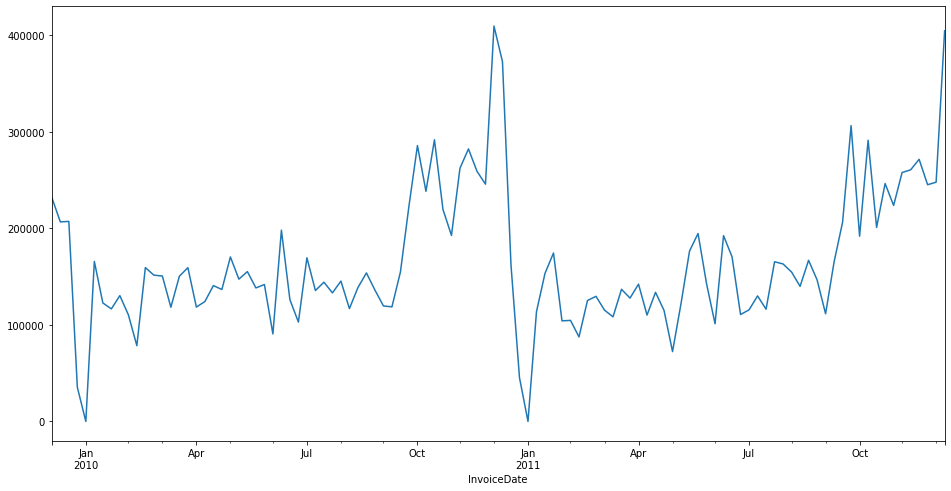

In [17]:
time_series = df.groupby('InvoiceDate')['TotalPrice'].sum()
time_series_weekly = time_series.resample('W').sum()
time_series_weekly.plot();

In [18]:
from pmdarima.arima import auto_arima #https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html

Hyperparameter grid search:

In [19]:
stepwise_model = auto_arima(time_series_weekly, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1352.452, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1321.421, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1321.685, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=1321.875, Time=1.92 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=1320.436, Time=0.72 sec
 ARIMA(1,1,0)(0,1,2)[52]             : AIC=1322.067, Time=1.84 sec
 ARIMA(1,1,0)(1,1,2)[52]             : AIC=inf, Time=3.84 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1327.995, Time=0.67 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=1.07 sec
 ARIMA(2,1,1)(0,1,1)[52]             : AIC=inf, Time=3.19 sec
 ARIMA(1,1,0)(0,1,1)[52] intercept   : AIC=1322.080, Time=0.86 sec

Best model:  ARIMA(1,1,0)(0,1,1)[52]          
T

Use the last 4 weeks as test set:

In [20]:
train = time_series_weekly.iloc[:-4]
test = time_series_weekly.iloc[-4:]

In [21]:
stepwise_model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 52),
      suppress_warnings=True, with_intercept=False)

In [22]:
future_forecast = stepwise_model.predict(n_periods=4)

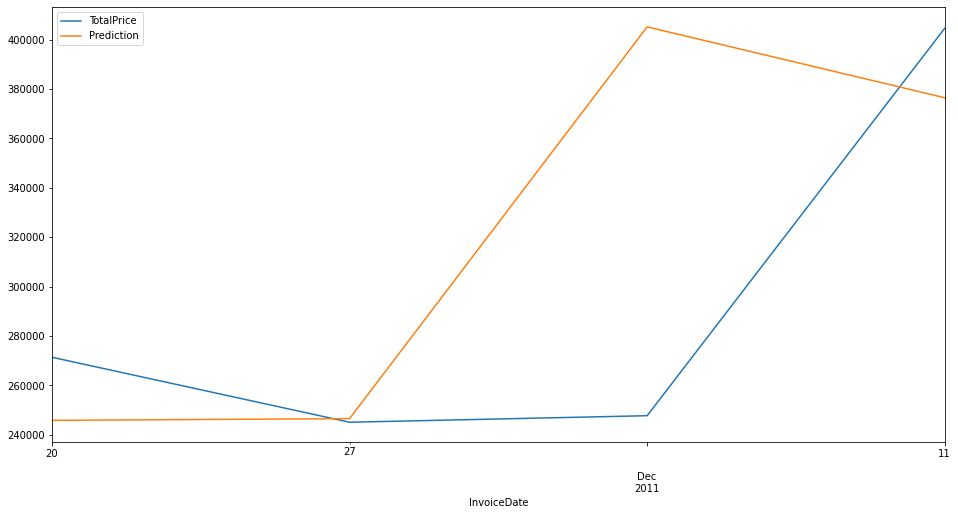

In [23]:
future_forecast = pd.DataFrame(future_forecast,index = test.index, columns=['Prediction'])
pd.concat([test, future_forecast],axis=1).plot();

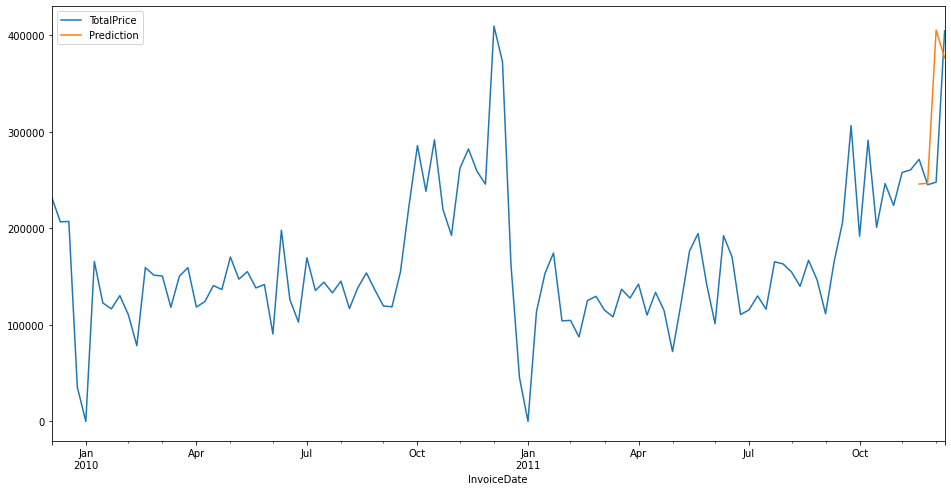

In [24]:
pd.concat([time_series_weekly, future_forecast],axis=1).plot();

<a id='churn'></a>
## 2. Puchase prediction:

<b>Task:</b> Make a model, which allows estimating if a given customer will buy again something from
the online shop in the next quarter.

The technique is inspired by the paper https://link.springer.com/content/pdf/10.1057%2Fdbm.2012.17.pdf. When looking at what other people on Kaggle do, https://www.kaggle.com/mashlyn/online-retail-ii-uci/code, it seems like a lot of them have also read that paper:)

We will associate 3 core features to each user: 
* Frequency, i.e., how often did they buy in a given period, 
* Recency, i.e., when did they buy the last time, 
* Monetary value, i.e. how much did they spend overall.

Then we cluster the users based on these features using KMeans and add the IDs of the clusters that the users belong to as features. Based on this we train binary classifiers to predict whether customers will make another purchase within the next 90 days. 

In [25]:
from sklearn.cluster import KMeans

In [26]:
NOW = pd.Timestamp(2011,9,1)

In [27]:
def get_features(dfr, NOW=NOW):
    df_before = df[(df.InvoiceDate < NOW)].reset_index(drop=True)
    df_after = df[(df.InvoiceDate >= NOW)].reset_index(drop=True)
    
    df_customers = pd.DataFrame(df_before['Customer ID'].unique())
    df_customers.columns = ['Customer ID']
    
    #Create the target variable which is 1 if the user makes a puchase 90 days from his and otherwise 0:
    
    ctm_1st_purchase_in_next_quarter = df_after.groupby('Customer ID').InvoiceDate.min().reset_index()
    ctm_1st_purchase_in_next_quarter.columns = ['Customer ID','MinPurchaseDate']
    
    ctm_last_purchase_bhvr_dt = df_before.groupby('Customer ID').InvoiceDate.max().reset_index()
    ctm_last_purchase_bhvr_dt.columns = ['Customer ID','MaxPurchaseDate']
    
    ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='Customer ID', 
                              how='left')
    
    ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days
    
    df_customers = pd.merge(df_customers, ctm_purchase_dates[['Customer ID','NextPurchaseDay']], on='Customer ID', how='left')
    
    df_customers = df_customers.fillna(9999)
    
    df_customers['NextPurchaseDayRange'] = 1
    df_customers.loc[df_customers.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0 
    
    df_customers = df_customers.drop('NextPurchaseDay', axis=1)
    
    #Features:
    
    #Recency:
    ctm_max_purchase = df_before.groupby('Customer ID').InvoiceDate.max().reset_index()
    ctm_max_purchase.columns = ['Customer ID','MaxPurchaseDate']
    
    ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days
    df_customers = pd.merge(df_customers, ctm_max_purchase[['Customer ID', 'Recency']], on='Customer ID')
    
    number_of_clusters=4 #the value from the paper:
    
    kmeans = KMeans(n_clusters=number_of_clusters)
    kmeans.fit(df_customers[['Recency']])
    df_customers['RecencyCluster'] = kmeans.predict(df_customers[['Recency']])
    
    #Frequency
    ctm_frequency = df.groupby('Customer ID').InvoiceDate.count().reset_index()
    ctm_frequency.columns = ['Customer ID','Frequency']
    
    df_customers = pd.merge(df_customers, ctm_frequency, on='Customer ID')
    
    kmeans = KMeans(n_clusters=number_of_clusters)
    kmeans.fit(df_customers[['Frequency']])
    df_customers['FrequencyCluster'] = kmeans.predict(df_customers[['Frequency']])
    
    
    #Monetary value:
    df['Revenue'] = df.Price * df.Quantity #WIESO DF?
    
    ctm_revenue = df.groupby('Customer ID').Revenue.sum().reset_index()

    df_customers = pd.merge(df_customers, ctm_revenue, on='Customer ID')
    
    kmeans = KMeans(n_clusters=number_of_clusters)
    kmeans.fit(df_customers[['Revenue']])
    df_customers['RevenueCluster'] = kmeans.predict(df_customers[['Revenue']])
    
    #Overall score:
    df_customers['OverallScore'] = df_customers['RecencyCluster'] + df_customers['FrequencyCluster'] + df_customers['RevenueCluster']
    
    df_customers['Segment'] = 'Low-Value'
    df_customers.loc[df_customers['OverallScore'] > 4, 'Segment'] = 'Mid-Value'
    df_customers.loc[df_customers['OverallScore'] > 6, 'Segment'] = 'High-Value'
    
    #One hot encode the segments:
    df_customers = pd.get_dummies(df_customers, drop_first=True)
    
    return df_customers

Extract the customer features:

In [28]:
df_customer_features = get_features(df)
df_customer_features.head()

,Customer ID,NextPurchaseDayRange,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_Low-Value,Segment_Mid-Value
0,13085.0,0,57,1,84,0,2433.28,0,1,1,0
1,13078.0,1,6,1,801,2,29532.45,3,6,0,1
2,15362.0,0,348,0,40,0,613.08,0,0,1,0
3,18102.0,1,26,1,1058,2,608821.65,2,5,0,1
4,12682.0,1,0,1,989,2,21693.91,0,3,1,0


Train-test split:

In [29]:
X = df_customer_features.drop('NextPurchaseDayRange', axis=1) 
y = df_customer_features['NextPurchaseDayRange']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

Instead of trying out different classifiers our selves and doing hyperparameter grid searches, we use the AutoML package from https://supervised.mljar.com/. Detailed reports about the various models can be found in the folders AutoML_xy:

In [30]:
from supervised.automl import AutoML

automl = AutoML()
automl.fit(X_train, y_train)

y_test_pred = automl.predict(X_test)

AutoML directory: AutoML_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.482665 trained in 0.37 seconds
2_DecisionTree logloss 0.211494 trained in 10.78 seconds
3_Linear logloss 0.201925 trained in 3.25 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.213518 trained in 5.96 seconds
5_Default_NeuralNetwork logloss 0.201242 trained in 2.59 seconds
6_Default_RandomForest logloss 0.198577 trained in 4.18 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.194214 trained in 0.97 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 41.97 seconds
AutoML best model: Ensemble


An ensemble model achieves the highest accuracy:

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f"Accuracy: {accuracy_score(y_test, y_test_pred)*100.0:.2f}%" )
print(f"Precision: {precision_score(y_test, y_test_pred)*100.0:.2f}%" )
print(f"Recall: {recall_score(y_test, y_test_pred)*100.0:.2f}%" )

Accuracy: 91.00%
Precision: 70.81%
Recall: 76.61%


We check the effect of the size of the training set and the length of the purchase history:

In [32]:
NOWs = [pd.Timestamp(2010,1,1), pd.Timestamp(2010,4,1), pd.Timestamp(2010,7,1), pd.Timestamp(2010,10,1),
        pd.Timestamp(2011,1,1), pd.Timestamp(2011,4,1), pd.Timestamp(2011,7,1), pd.Timestamp(2011,10,1)]

TEST_SIZEs = [0.2, 0.5, 0.8]

results = []

for NOW in NOWs:
    for TEST_SIZE in TEST_SIZEs:
        df_customer_features = get_features(df, NOW=NOW)
        X = df_customer_features.drop('NextPurchaseDayRange', axis=1) 
        y = df_customer_features.NextPurchaseDayRange
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=24)
    
        automl = AutoML()
        automl.fit(X_train, y_train)

        y_test_pred = automl.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        
        results.append((accuracy, precision, recall, NOW, TEST_SIZE))

AutoML directory: AutoML_2
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.689603 trained in 0.92 seconds
2_DecisionTree logloss 0.577978 trained in 4.42 seconds
3_Linear logloss 0.552159 trained in 2.86 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.566293 trained in 4.18 seconds
5_Default_NeuralNetwork logloss 0.597716 trained in 1.27 seconds
6_Default_RandomForest logloss 0.537233 trained in 3.75 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.534488 trained in 0.81 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 29.01 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_3
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.690318 trained in 0.6 seconds
2_DecisionTree logloss 0.584014 trained in 4.27 seconds
3_Linear logloss 0.47058 trained in 3.18 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.51058 trained in 4.77 seconds
5_Default_NeuralNetwork logloss 0.531859 trained in 1.47 seconds
6_Default_RandomForest logloss 0.493493 trained in 5.16 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.463008 trained in 0.83 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 31.0 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_4
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.692659 trained in 0.86 seconds
2_DecisionTree logloss 0.47935 trained in 4.64 seconds
3_Linear logloss 0.488301 trained in 3.07 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.470823 trained in 4.69 seconds
5_Default_NeuralNetwork logloss 0.583011 trained in 1.39 seconds
6_Default_RandomForest logloss 0.433247 trained in 3.69 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.432126 trained in 0.58 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 29.43 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_5
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.675934 trained in 1.18 seconds
2_DecisionTree logloss 0.499752 trained in 5.91 seconds
3_Linear logloss 0.471167 trained in 4.49 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.466828 trained in 6.12 seconds
5_Default_NeuralNetwork logloss 0.488927 trained in 2.6 seconds
6_Default_RandomForest logloss 0.443009 trained in 4.83 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.43735 trained in 0.93 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 39.15 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_6
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.678883 trained in 1.39 seconds
2_DecisionTree logloss 0.45301 trained in 5.36 seconds
3_Linear logloss 0.406253 trained in 4.14 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.416849 trained in 5.85 seconds
5_Default_NeuralNetwork logloss 0.498655 trained in 2.74 seconds
6_Default_RandomForest logloss 0.423431 trained in 5.25 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.399514 trained in 0.87 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 37.57 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_7
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.677338 trained in 1.68 seconds
2_DecisionTree logloss 0.391172 trained in 5.63 seconds
3_Linear logloss 0.380961 trained in 4.4 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.36689 trained in 6.09 seconds
5_Default_NeuralNetwork logloss 0.345468 trained in 2.69 seconds
6_Default_RandomForest logloss 0.367152 trained in 5.04 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.326759 trained in 0.88 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 37.86 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_8
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.616503 trained in 1.92 seconds
2_DecisionTree logloss 0.344111 trained in 6.54 seconds
3_Linear logloss 0.357021 trained in 5.01 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.348615 trained in 7.89 seconds
5_Default_NeuralNetwork logloss 0.342775 trained in 3.37 seconds
6_Default_RandomForest logloss 0.329088 trained in 5.78 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.328369 trained in 0.98 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 44.9 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_9
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.620422 trained in 2.23 seconds
2_DecisionTree logloss 0.316505 trained in 6.18 seconds
3_Linear logloss 0.317953 trained in 5.11 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.330761 trained in 7.62 seconds
5_Default_NeuralNetwork logloss 0.311633 trained in 3.49 seconds
6_Default_RandomForest logloss 0.289154 trained in 6.01 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.289154 trained in 0.96 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 43.12 seconds
AutoML best model: 6_Default_RandomForest
AutoML directory: AutoML_10
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.625024 trained in 2.45 seconds
2_DecisionTree logloss 0.452345 trained in 7.07 seconds
3_Linear logloss 0.378941 trained in 5.33 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.359663 trained in 7.23 seconds
5_Default_NeuralNetwork logloss 0.569535 trained in 3.36 seconds
6_Default_RandomForest logloss 0.336298 trained in 6.85 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.336222 trained in 0.89 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 44.95 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_11
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.620809 trained in 2.77 seconds
2_DecisionTree logloss 0.288279 trained in 7.26 seconds
3_Linear logloss 0.301715 trained in 5.88 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.272209 trained in 8.2 seconds
5_Default_NeuralNetwork logloss 0.27794 trained in 4.29 seconds
6_Default_RandomForest logloss 0.264991 trained in 6.88 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.264386 trained in 1.0 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 50.35 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_12
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.625571 trained in 3.05 seconds
2_DecisionTree logloss 0.29802 trained in 7.54 seconds
3_Linear logloss 0.335226 trained in 5.86 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.319603 trained in 7.78 seconds
5_Default_NeuralNetwork logloss 0.286938 trained in 4.35 seconds
6_Default_RandomForest logloss 0.287313 trained in 9.45 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.281038 trained in 1.0 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 51.04 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_13
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.636536 trained in 3.31 seconds
2_DecisionTree logloss 0.365665 trained in 8.04 seconds
3_Linear logloss 0.300362 trained in 6.13 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.284317 trained in 7.84 seconds
5_Default_NeuralNetwork logloss 0.28803 trained in 4.23 seconds
6_Default_RandomForest logloss 0.278821 trained in 7.23 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.272247 trained in 0.91 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 49.52 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_14
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.467257 trained in 3.56 seconds
2_DecisionTree logloss 0.272056 trained in 8.96 seconds
3_Linear logloss 0.248899 trained in 6.76 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.238913 trained in 8.77 seconds
5_Default_NeuralNetwork logloss 0.238806 trained in 5.64 seconds
6_Default_RandomForest logloss 0.231901 trained in 8.07 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.225024 trained in 1.2 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 56.45 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_15
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.476413 trained in 3.85 seconds
2_DecisionTree logloss 0.258795 trained in 9.07 seconds
3_Linear logloss 0.223791 trained in 6.82 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.227225 trained in 9.47 seconds
5_Default_NeuralNetwork logloss 0.21614 trained in 5.49 seconds
6_Default_RandomForest logloss 0.21696 trained in 10.63 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.21314 trained in 0.93 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 59.17 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_16
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.492614 trained in 4.1 seconds
2_DecisionTree logloss 0.376536 trained in 8.91 seconds
3_Linear logloss 0.253248 trained in 7.07 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.253364 trained in 8.49 seconds
5_Default_NeuralNetwork logloss 0.302496 trained in 5.21 seconds
6_Default_RandomForest logloss 0.198755 trained in 7.87 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.198755 trained in 0.92 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 54.81 seconds
AutoML best model: 6_Default_RandomForest
AutoML directory: AutoML_17
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.45848 trained in 4.55 seconds
2_DecisionTree logloss 0.224708 trained in 9.47 seconds
3_Linear logloss 0.203412 trained in 7.73 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.207765 trained in 10.39 seconds
5_Default_NeuralNetwork logloss 0.199905 trained in 6.44 seconds
6_Default_RandomForest logloss 0.193972 trained in 8.64 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.187215 trained in 1.14 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 63.27 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_18
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.467081 trained in 4.69 seconds
2_DecisionTree logloss 0.223857 trained in 9.64 seconds
3_Linear logloss 0.208349 trained in 7.69 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.22692 trained in 10.24 seconds
5_Default_NeuralNetwork logloss 0.227359 trained in 6.5 seconds
6_Default_RandomForest logloss 0.204841 trained in 10.58 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.200329 trained in 1.07 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 63.5 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_19
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.456236 trained in 5.36 seconds
2_DecisionTree logloss 0.334855 trained in 9.86 seconds
3_Linear logloss 0.240109 trained in 7.94 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.237053 trained in 9.8 seconds
5_Default_NeuralNetwork logloss 0.267218 trained in 6.14 seconds
6_Default_RandomForest logloss 0.221271 trained in 9.88 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.213031 trained in 0.93 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 61.91 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_20
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.458234 trained in 5.33 seconds
2_DecisionTree logloss 0.187245 trained in 11.16 seconds
3_Linear logloss 0.194885 trained in 8.63 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.19018 trained in 10.3 seconds
5_Default_NeuralNetwork logloss 0.190193 trained in 7.23 seconds
6_Default_RandomForest logloss 0.179745 trained in 11.94 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.179745 trained in 1.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 71.11 seconds
AutoML best model: 6_Default_RandomForest
AutoML directory: AutoML_21
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.471732 trained in 5.62 seconds
2_DecisionTree logloss 0.212507 trained in 11.74 seconds
3_Linear logloss 0.24497 trained in 8.71 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.236518 trained in 11.18 seconds
5_Default_NeuralNetwork logloss 0.241832 trained in 7.19 seconds
6_Default_RandomForest logloss 0.214077 trained in 10.13 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.209954 trained in 1.02 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 68.81 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_22
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.476331 trained in 5.85 seconds
2_DecisionTree logloss 0.247974 trained in 11.25 seconds
3_Linear logloss 0.284546 trained in 8.81 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.249211 trained in 10.79 seconds
5_Default_NeuralNetwork logloss 0.299174 trained in 7.31 seconds
6_Default_RandomForest logloss 0.239923 trained in 10.43 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.238496 trained in 0.93 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 67.47 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_23
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.525432 trained in 6.96 seconds
2_DecisionTree logloss 0.232637 trained in 14.79 seconds
3_Linear logloss 0.251612 trained in 10.59 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.238595 trained in 13.77 seconds
5_Default_NeuralNetwork logloss 0.255966 trained in 10.07 seconds
6_Default_RandomForest logloss 0.222712 trained in 11.93 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.222106 trained in 1.36 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 86.52 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_24
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.521356 trained in 7.93 seconds
2_DecisionTree logloss 0.268065 trained in 14.05 seconds
3_Linear logloss 0.242094 trained in 10.85 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.247828 trained in 13.56 seconds
5_Default_NeuralNetwork logloss 0.263096 trained in 10.74 seconds
6_Default_RandomForest logloss 0.224349 trained in 12.89 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.220178 trained in 1.2 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 86.92 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_25
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.537811 trained in 7.59 seconds
2_DecisionTree logloss 0.414265 trained in 14.61 seconds
3_Linear logloss 0.279636 trained in 10.7 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.260037 trained in 14.49 seconds
5_Default_NeuralNetwork logloss 0.345241 trained in 9.64 seconds
6_Default_RandomForest logloss 0.235867 trained in 12.27 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.235867 trained in 1.09 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 84.62 seconds
AutoML best model: 6_Default_RandomForest


The results:

In [33]:
results_df = pd.DataFrame(results)
results_df.columns = ['accuracy','precision', 'recall', 'now', 'test_size']
results_df.groupby(['now', 'test_size']).sum()

accuracy  precision  recall
now        test_size                             
2010-01-01 0.2           0.707      0.771   0.634
           0.5           0.723      0.794   0.665
           0.8           0.687      0.786   0.590
2010-04-01 0.2           0.778      0.799   0.624
           0.5           0.785      0.725   0.748
           0.8           0.778      0.729   0.725
2010-07-01 0.2           0.826      0.703   0.682
           0.5           0.828      0.682   0.776
           0.8           0.831      0.698   0.766
2010-10-01 0.2           0.840      0.717   0.741
           0.5           0.851      0.756   0.733
           0.8           0.845      0.678   0.925
2011-01-01 0.2           0.899      0.726   0.531
           0.5           0.892      0.666   0.662
           0.8           0.888      0.777   0.456
2011-04-01 0.2           0.894      0.802   0.518
           0.5           0.916      0.764   0.729
           0.8           0.910      0.809   0.628
2011-07-01 0.2           0.884      0.651   0.805
           0.5           0.902      0.681   0.786
           0.8           0.893      0.666   0.758
2011-10-01 0.2           0.906      0.809   0.649
           0.5           0.899      0.751   0.771
           0.8           0.884      0.667   0.887

<a id='recommend'></a>
## 3. Product recommendation:

<b>Task:</b> What products are likely to land together in the basket (i.e. which product can be
recommended as a second article in the basket, if there has already an product be placed).

To solve this task we collect the frequency distribution of the products, that is, we count how often they were bought in the training set. We also collect the product 'bigram' frequency distribution, i.e., we count how often products were bought together within baskets. Since products within a basket have the same `InvoiceDate` we have to treat the baskets as sets rather than sequences. Then we calculate various association measures based on these two distributions such as lift or point-wise mutual information and write them into sparse matrices. These matrices are then factorized using SVD.<br><br> During evaluation we pick one product from each basket in the test set uniformly at random and recommend the product with the strongest association to that given product. If the recommended product happens to also be contained in that basket, we increase the score by one. Then we check for what fraction of test baskets we have made a correct recommendation and use this as our evaluation metric.<br><br>This is a form of unpersonalized recommendation, since we are asking: Given product $i$, recommend product $j$, but not, given product $i$ and customer $k$, recommend product $j$.

The implementation is based on the notebook https://www.kaggle.com/gabrielaltay/word-vectors-from-pmi-matrix/notebook, which in turn is based on the paper https://transacl.org/ojs/index.php/tacl/article/view/570. A systematic study of the influence of the hyperparameter `alpha` in a recommandation setting can be found in https://arxiv.org/abs/1804.04212. 

In [34]:
baskets = df.groupby('Invoice')['StockCode'].apply(list).to_list()
print('Number of baskets: ', len(baskets), '\n')
print(baskets[:3])

Number of baskets:  36594 

[['85048', '79323P', '79323W', '22041', '21232', '22064', '21871', '21523'], ['22350', '22349', '22195', '22353'], ['48173C', '21755', '21754', '84879', '22119', '22142', '22296', '22295', '22109', '22107', '22194', '35004B', '82582', '21181', '21756', '21333', '84596F', '84596L', '22111']]


We remove baskets containing only one product:

In [35]:
baskets = [basket for basket in baskets if len(basket) > 1]
print('Number of baskets containing at least 2 products:', len(baskets))

Number of baskets containing at least 2 products: 33927


Split:

In [36]:
baskets_train = baskets[:30000]
baskets_test = baskets[30000:]

Unigram distribution:

In [37]:
unigram_counts = Counter()
for ii, basket in enumerate(baskets):
    if ii % 10000 == 0:
        print(f'finished {ii/len(baskets):.2%} of baskets')
    for token in basket:
        unigram_counts[token] += 1

tok2indx = {tok: indx for indx, tok in enumerate(unigram_counts.keys())}
indx2tok = {indx: tok for tok,indx in tok2indx.items()}
print('done')
print('number of distinct products: {}'.format(len(unigram_counts)))
print('most common: {}'.format(unigram_counts.most_common(5)))

finished 0.00% of baskets
finished 29.48% of baskets
finished 58.95% of baskets
finished 88.43% of baskets
done
number of distinct products: 4614
most common: [('85123A', 5138), ('22423', 3376), ('85099B', 3328), ('84879', 2766), ('20725', 2677)]


The distribution of pairs of products co-occuring in baskets:

In [38]:
skipgram_counts = Counter()
for iheadline, basket in enumerate(baskets):
    tokens = [tok2indx[tok] for tok in basket]
    pairs_of_tokens = list(permutations(tokens, 2))
    for pair in pairs_of_tokens:
        skipgram_counts[pair] += 1    
    if iheadline % 10000 == 0:
        print(f'finished {iheadline/len(baskets):.2%} of baskets')
        
print('done\n')
print('number of pairs: {}'.format(len(skipgram_counts)))
most_common = [
    (indx2tok[sg[0][0]], indx2tok[sg[0][1]], sg[1]) 
    for sg in skipgram_counts.most_common(10)]
print('most common: {}'.format(most_common))

finished 0.00% of baskets
finished 29.48% of baskets
finished 58.95% of baskets
finished 88.43% of baskets
done

number of pairs: 6852139
most common: [('21733', '85123A', 1346), ('85123A', '21733', 1346), ('20727', '20725', 1167), ('20725', '20727', 1167), ('85099B', '22386', 1161), ('22386', '85099B', 1161), ('22384', '20725', 1158), ('20725', '22384', 1158), ('82494L', '82482', 1138), ('82482', '82494L', 1138)]


As sparse matrix:

In [39]:
row_indxs = []
col_indxs = []
dat_values = []
ii = 0
for (tok1, tok2), sg_count in skipgram_counts.items():
    ii += 1
    if ii % 500000 == 0:
        print(f'finished {ii/len(skipgram_counts):.2%} of product pairs')    
    row_indxs.append(tok1)
    col_indxs.append(tok2)
    dat_values.append(sg_count)
wwcnt_mat = sparse.csr_matrix((dat_values, (row_indxs, col_indxs)))
print('done')

finished 7.30% of product pairs
finished 14.59% of product pairs
finished 21.89% of product pairs
finished 29.19% of product pairs
finished 36.48% of product pairs
finished 43.78% of product pairs
finished 51.08% of product pairs
finished 58.38% of product pairs
finished 65.67% of product pairs
finished 72.97% of product pairs
finished 80.27% of product pairs
finished 87.56% of product pairs
finished 94.86% of product pairs
done


$L2$-normalize:

In [40]:
wwcnt_norm_mat = normalize(wwcnt_mat, norm='l2', axis=1)

Calculate some association measures:

In [41]:
num_skipgrams = wwcnt_mat.sum()
assert(sum(skipgram_counts.values())==num_skipgrams)

row_indxs = []
col_indxs = []

pmi_dat_values = []    # pointwise mutual information
ppmi_dat_values = []   # positive pointwise mutial information
spmi_dat_values = []   # smoothed pointwise mutual information
sppmi_dat_values = []  # smoothed positive pointwise mutual information

# reusable quantities

# sum_over_rows[ii] = sum_over_words[ii] = wwcnt_mat.getcol(ii).sum()
sum_over_words = np.array(wwcnt_mat.sum(axis=0)).flatten()
# sum_over_cols[ii] = sum_over_contexts[ii] = wwcnt_mat.getrow(ii).sum()
sum_over_contexts = np.array(wwcnt_mat.sum(axis=1)).flatten()

# smoothing
alpha = 0.75
sum_over_words_alpha = sum_over_words**alpha
nca_denom = np.sum(sum_over_words_alpha)

ii = 0
for (tok_word, tok_context), sg_count in skipgram_counts.items():

    ii += 1
    if ii % 500000 == 0:
        print(f'finished {ii/len(skipgram_counts):.2%} of skipgrams')
    
    nwc = sg_count
    Pwc = nwc / num_skipgrams
    nw = sum_over_contexts[tok_word]
    Pw = nw / num_skipgrams
    nc = sum_over_words[tok_context]
    Pc = nc / num_skipgrams
    
    nca = sum_over_words_alpha[tok_context]
    Pca = nca / nca_denom
    
    pmi = np.log2(Pwc/(Pw*Pc))   
    ppmi = max(pmi, 0)
    spmi = np.log2(Pwc/(Pw*Pca))
    sppmi = max(spmi, 0)
    
    row_indxs.append(tok_word)
    col_indxs.append(tok_context)
    pmi_dat_values.append(pmi)
    ppmi_dat_values.append(ppmi)
    spmi_dat_values.append(spmi)
    sppmi_dat_values.append(sppmi)
        
pmi_mat = sparse.csr_matrix((pmi_dat_values, (row_indxs, col_indxs)))
ppmi_mat = sparse.csr_matrix((ppmi_dat_values, (row_indxs, col_indxs)))
spmi_mat = sparse.csr_matrix((spmi_dat_values, (row_indxs, col_indxs)))
sppmi_mat = sparse.csr_matrix((sppmi_dat_values, (row_indxs, col_indxs)))

print('done')

finished 7.30% of skipgrams
finished 14.59% of skipgrams
finished 21.89% of skipgrams
finished 29.19% of skipgrams
finished 36.48% of skipgrams
finished 43.78% of skipgrams
finished 51.08% of skipgrams
finished 58.38% of skipgrams
finished 65.67% of skipgrams
finished 72.97% of skipgrams
finished 80.27% of skipgrams
finished 87.56% of skipgrams
finished 94.86% of skipgrams
done


We use positive pointwise mutual information and apply a singular value decomposition:

In [42]:
pmi_use = ppmi_mat
embedding_size = 50
uu, ss, vv = linalg.svds(pmi_use, embedding_size) 

In [43]:
unorm = uu / np.sqrt(np.sum(uu*uu, axis=1, keepdims=True))
vnorm = vv / np.sqrt(np.sum(vv*vv, axis=0, keepdims=True))
word_vecs = uu + vv.T
word_vecs_norm = word_vecs / np.sqrt(np.sum(word_vecs*word_vecs, axis=1, keepdims=True))

Find the products whose feature vectors have the largest cosine similarity with a given feature vector: 

In [44]:
def ww_sim(word, matrix, unigram_counts=None, n=1):
    indx = tok2indx[word]
    if isinstance(matrix, sparse.csr_matrix):
        v1 = matrix.getrow(indx)
    else:
        v1 = matrix[indx:indx+1, :]
    sims = cosine_similarity(matrix, v1).flatten()
    sindxs = np.argsort(-sims)
    sim_word_scores = [indx2tok[sindx] for sindx in sindxs[1:n+1]]
    return sim_word_scores

In [45]:
ww_sim('21733', pmi_mat, n=3)

['85123A', '22470', '21181']

For comparison, we define two 'recommenders'. One which recommends products uniformly at random, independently of the first product in the basket. And another one which samples products from the unigram frequency distribution, also independently of the first item in the basket.

In [46]:
from random import sample, choice

In [47]:
def random_recommendation(word=None, matrix=None, unigram_counts=unigram_counts, n=1):
    return sample(list(unigram_counts), n)

In [48]:
def recommendation_according_to_frequency(word=None, matrix=None, unigram_counts=unigram_counts, n=1):
    total = float(sum(unigram_counts.values()))
    unigram_probabilities = {k:v/total for k,v in unigram_counts.items()}
    sample = np.random.choice(list(unigram_probabilities), p=list(unigram_probabilities.values()), size=n)
    return list(sample)

In [49]:
recommendation_according_to_frequency(unigram_counts, n=3)

['22471', '22726', '23168']

Finally, we evaluate on the test set and compare:

In [50]:
def evaluate(recommender=ww_sim, test_baskets=baskets_test, unigram_counts=unigram_counts, matrix=pmi_mat, n=1):
    sims=[]
    correct_guesses=0
    for test_basket in test_baskets:
        word = choice(test_basket)
        sims = recommender(word, matrix, unigram_counts, n=n)
        for sim in sims:
            if sim in test_basket:
                correct_guesses+=1
                break
    return correct_guesses, len(test_baskets)

$k$ is the number of recommendations made per test basket:

In [51]:
results = []
for recommender in [('random', random_recommendation),
                    ('product_frequency', recommendation_according_to_frequency),
                    ('ppmi', ww_sim)]:
    
    for k in [1,2,3,5,10,100]:
        
        correct, test_size = evaluate(recommender=recommender[1], test_baskets=baskets_test, n=k)
        results.append((recommender[0], correct, test_size, k, round(100*correct/test_size, 2)))

The results:

In [52]:
results_df = pd.DataFrame(results)
results_df.columns = ['recommender','n_correct', 'test_size', 'k',  'percent']
results_df

,recommender,n_correct,test_size,k,percent
0,random,16,3927,1,0.41
1,random,35,3927,2,0.89
2,random,69,3927,3,1.76
3,random,97,3927,5,2.47
4,random,221,3927,10,5.63
5,random,1365,3927,100,34.76
6,product_frequency,73,3927,1,1.86
7,product_frequency,148,3927,2,3.77
8,product_frequency,208,3927,3,5.30
9,product_frequency,323,3927,5,8.23
